In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import normalize

def conv_circ(signal, kernal, n=None):
    '''
    Parameters
    ----------
    
    signal: array of length D
    
    ker: array of length D   

    Returns
    -------
    
    array of length D
    
    '''
    if n == None:
        n = len(signal) + len(kernal) - 1
        
    return np.real(np.fft.ifft(np.fft.fft(signal, n)*np.fft.fft(kernal, n) ))

def plate_formula(n, k, err):
    '''
    Determine the number of dimensions needed according to Plate's (2003)
    formula:
      D = 3.16(K-0.25)ln(N/err^3)
    where D is the number of dimensions, K is the maximum number of terms
    to be combined, N is the number of atomic values in the langauge, and
    err is the probability of error.
    
    USAGE: D = plate_formula(n, k, err)
    '''
    return int(round(3.16 * (k-0.25) * (np.log(n) - 3 * np.log(err))))


def embed(n, d, distr='spikeslab_gaussian', param=None):
    # Embed symbols in a vector space.
    #
    # USAGE: X = embed(n, d, distr='spikeslab_gaussian', param=None)
    #
    # INPUTS:
    #   n - number of symbols
    #   d - number of dimensions
    #   distr - string specifying the distribution on the vector space:
    #           'spikeslab_gaussian' - mixture of Gaussian "slab" and Bernoulli "spike"
    #           'spikeslab_uniform' - mixture of uniform "slab" and Bernoulli "spike"
    #
    #   param (optional) - parameters of the distribution:
    #                      'spikeslab_gaussian' - param = [variance, spike probability] (default: [1 1])
    #                      'spikeslab_uniform' - param = [bound around 0, spike probability] (default: [1 1])
    # OUTPUTS;
    #   X - [N x D] matrix
    #
    # Sam Gershman, Jan 2013
    
    if param is None:
        param = [1, 1]
    spike = np.round(np.random.rand(n, d) < param[1])
    
    if distr == 'spikeslab_gaussian':
        slab = np.random.randn(n, d) * param[1]
    elif distr == 'spikeslab_uniform':
        slab = np.random.uniform(-param[1], param[1], (n, d))
    else:
        raise(Exception)
    
    return normalize(spike * slab)
        
            
        
def encode(a, b):
    return normalize(conv_circ(a, b, np.size(a)))

def decode(a, b):
    c = np.real(np.fft.ifft(np.fft.fft(a, np.size(a)) * np.conj(np.fft.fft(b, np.size(a))) ) )
    return c

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[[ 1.          0.50280382]
 [ 0.50280382  1.        ]]


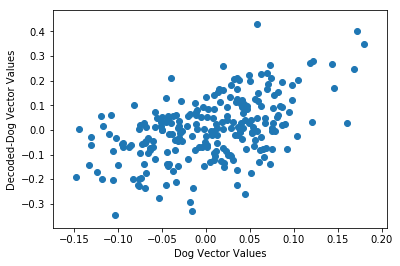

In [2]:
# figure out how many dimensions we need
n = 10;     # vocabulary size
k = 5;      # maximum number of terms to be combined
err = 0.01; # error probability
d = plate_formula(n, k, err);

# embedding parameters
distr = 'spikeslab_gaussian'
param = [1.0, 1.0]

dog = embed(1, d, distr, param)
agent = embed(1, d, distr, param)
chase = embed(1, d, distr, param)
verb = embed(1, d, distr, param)
cat = embed(1, d, distr, param)
patient = embed(1, d, distr, param)

sentance = encode(dog, agent) + encode(chase, verb)# + encode(cat, patient)
dog_decoded = decode(sentance, agent)

plt.scatter(dog, dog_decoded)
print np.corrcoef(dog, dog_decoded)
plt.gca().set_xlabel('Dog Vector Values')
plt.gca().set_ylabel('Decoded-Dog Vector Values')
plt.show()

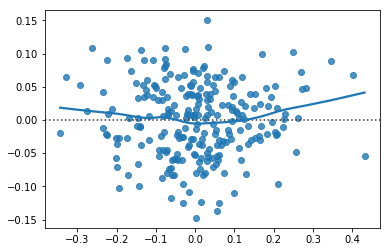

In [3]:
import seaborn as sns
sns.residplot(np.squeeze(dog_decoded), np.squeeze(dog), lowess=True)
# doesn't look like there is any structure to these residuals

Channel Capacity of Encoding/Decoding Algorithm: 0.08 bits


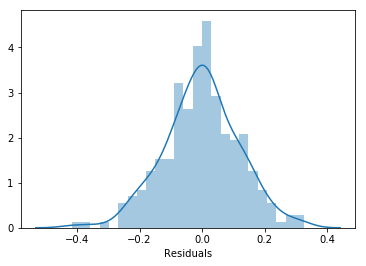

In [4]:
# I think the encoding/decoding algorithm can be interpreted as a guassian channel
# hense, calculate the channel capacity
res = sm.OLS(dog, dog_decoded).fit()
x = res.predict(dog) - dog_decoded
sns.distplot(x, 25)
plt.gca().set_xlabel('Residuals')
c = 0.5 * np.log2(1 + np.mean(x ** 2 ) / np.std(x)) # channel capcity (via Shannon-Hartley theorem)
print "Channel Capacity of Encoding/Decoding Algorithm: %.02f bits" % c

# Compositonality
Circular convolution preserves the simliarity structure of the underlying vectors. That is, if two vectors are more are similar to each other in vector space, then their convolutions with a third vector will retain that similarity. 

Formally, if $\mathbf{a}$, $\mathbf{b}$, $\mathbf{c}$ and $\mathbf{d}$ are random unit vectors then 

$(\mathbf{a} + \mathbf{d}) \cdot (\mathbf{b} + \mathbf{d}) > \mathbf{a} \cdot \mathbf{b}$

and

$((\mathbf{a} + \mathbf{d})\otimes\mathbf{c}) \cdot ((\mathbf{a} + \mathbf{d})\otimes\mathbf{c}) > (\mathbf{a}\otimes\mathbf{c}) \cdot (\mathbf{b}\otimes\mathbf{a})$

where $\otimes$ is the tensor product operation.



In [5]:
from sklearn.preprocessing import normalize

isPerson = embed(1, d, distr, param)

Olivia = normalize(embed(1, d, distr, param) + isPerson)
William = normalize(embed(1, d, distr, param) + isPerson)
Agent = embed(1, d, distr, param)
Coffee = embed(1, d, distr, param)


OliviaAgent = encode(Olivia, Agent)
WilliamAgent = encode(William, Agent)
CoffeeAgent = encode(Coffee, Agent)

print "Dot Product:"
print 
print "dot(Olivia, William) = %.3f" % np.dot(OliviaAgent, WilliamAgent.T)[0][0]
print "dot(Olivia, Coffee)  = %.3f" % np.dot(CoffeeAgent, WilliamAgent.T)[0][0]
print "dot(Coffee, William) = %.3f" % np.dot(OliviaAgent, CoffeeAgent.T)[0][0]


print 
print "dot(Olivia(*)Agent, William(*)Agent) = %.3f" % np.dot(Olivia, William.T)[0][0]
print "dot(Olivia(*)Agent, Coffee(*)Agent)  = %.3f" % np.dot(Coffee, William.T)[0][0]
print "dot(Coffee(*)Agent, William(*)Agent) = %.3f" % np.dot(Olivia, Coffee.T)[0][0]


print
print "Euclidean Distance:"
print 
print "||Olivia - William|| = %.3f" % np.linalg.norm(Olivia - William)
print "||Olivia - Coffee || = %.3f" % np.linalg.norm(Olivia - Coffee)
print "||Coffee - William|| = %.3f" % np.linalg.norm(Coffee - William)

print
print "||Olivia(*)Agent - William(*)Agent|| = %.3f" % np.linalg.norm(OliviaAgent - WilliamAgent)
print "||Olivia(*)Agent - Coffee(*)Agent || = %.3f" % np.linalg.norm(CoffeeAgent - WilliamAgent)
print "||Coffee(*)Agent - William(*)Agent|| = %.3f" % np.linalg.norm(OliviaAgent - CoffeeAgent)



Dot Product:

dot(Olivia, William) = 0.466
dot(Olivia, Coffee)  = -0.006
dot(Coffee, William) = 0.132

dot(Olivia(*)Agent, William(*)Agent) = 0.493
dot(Olivia(*)Agent, Coffee(*)Agent)  = 0.003
dot(Coffee(*)Agent, William(*)Agent) = 0.009

Euclidean Distance:

||Olivia - William|| = 1.007
||Olivia - Coffee || = 1.408
||Coffee - William|| = 1.412

||Olivia(*)Agent - William(*)Agent|| = 1.033
||Olivia(*)Agent - Coffee(*)Agent || = 1.418
||Coffee(*)Agent - William(*)Agent|| = 1.317
